# **Part 2: Indexing and Evaluation**

## 0. Preparation and Text Processing

0.1 *Import libraries*

In [ ]:
!pip install --upgrade nltk
import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
nltk.download('stopwords')
import collections
from collections import defaultdict
from array import array
import math
import numpy as np
from numpy import linalg as la
import string
import json
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import spacy
from textblob import TextBlob
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


0.2 *Connect to Google Drive*

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
docs_path = '/content/drive/Shareddrives/IRWA Labs/PROJECT/IRWA - PROJECT DATA/farmers-protest-tweets.json' # modify path where are the documents

Mounted at /content/drive


0.3 *Read and preprocess tweets lines*

In [ ]:
with open(docs_path) as fp:
    lines = fp.readlines()
lines = [l.strip().replace(' +', ' ') for l in lines]

0.4 *Load and map tweets with IDs*

In [ ]:
excel_data = pd.read_csv('/content/drive/Shareddrives/IRWA Labs/PROJECT/IRWA - PROJECT DATA/tweet_document_ids_map.csv') # change path if necessary
tweet_id_to_doc_id = dict(zip(excel_data['id'], excel_data['docId']))

0.5 *Processing tweets (clean and normalize the content)*

In [ ]:
def build_terms(line):
    stemmer = PorterStemmer()
    stop_words = set(stopwords.words("english"))

    try:
        tweet_data = json.loads(line)
    except json.JSONDecodeError:
        print(f"Error: {line}")
        return None

    if tweet_data.get("lang") != "en": # only filter English tweets
        return None

    #Relevant information
    tweet_content = tweet_data.get("content", "")
    tweet_date = tweet_data.get("date", "")
    tweet_likes = tweet_data.get("likeCount", 0)
    tweet_retweets = tweet_data.get("retweetCount", 0)
    tweet_url = tweet_data.get("url", "")
    id = tweet_data.get("id", "")
    doc_id = tweet_id_to_doc_id.get(int(id))

    #Lowercase
    line = tweet_content.lower()

    #Tokenize
    line = line.split()

    #Punctuation signs
    line = [x.translate(str.maketrans('', '', string.punctuation)) for x in line]

    #Eliminate #
    hashtags = [word for word in tweet_content.split() if word.startswith('#')]

    #Stopwords
    line = [x for x in line if x not in stop_words and x]

    #Steaming
    line = [stemmer.stem(x) for x in line]

    #Return relevant information
    return {
        "tweet": line,
        "date": tweet_date,
        "hashtags": hashtags,
        "likes": tweet_likes,
        "retweets": tweet_retweets,
        "url": tweet_url,
        "id": id,
        "doc_id": doc_id
    }

0.6 *Apply text processing to all tweets and count the words in each tweet*

In [ ]:
processed_tweets = []
total_words = []
for line in lines:
    processed_tweet = build_terms(line)
    if processed_tweet:
        processed_tweets.append(processed_tweet)
        total_words.append(len(processed_tweet['tweet']))

In [ ]:
n_tweets = len(processed_tweets)
print(f"Total number of processed tweets: {n_tweets}")

Total number of processed tweets: 48429


## 1. Indexing

1.1 *Create inverted index*

In [ ]:
# Build the inverted index and calculate TF-IDF
inverted_index = defaultdict(set)
tfidf_scores = defaultdict(lambda: defaultdict(float))
tweet_lengths = defaultdict(int)
total_tweets = len(processed_tweets)

# Construct the inverted index and calculate TF-IDF
for tweet in processed_tweets:
    tweet_id = tweet["doc_id"]
    term_count = defaultdict(int)

    # Count term frequencies in the tweet
    for term in tweet["tweet"]:
        term_count[term] += 1
        inverted_index[term].add(tweet_id)

    # Calculate TF-IDF scores for each term in the tweet
    for term, count in term_count.items():
        # Term Frequency (TF)
        tf = count / len(tweet["tweet"])

        # Document Frequency (DF) for the term across tweets
        tweet_frequency = len(inverted_index[term])

        # Inverse Document Frequency (IDF)
        idf = math.log(total_tweets / (1 + tweet_frequency))

        # Calculate and store TF-IDF score for each term in the tweet
        tfidf_scores[tweet_id][term] = tf * idf

        # Update tweet length for normalization (sum of squared tf-idf scores)
        tweet_lengths[tweet_id] += (tf * idf) ** 2

# Finalize tweet lengths by taking the square root of summed squares (for normalization)
for tweet_id in tweet_lengths:
    tweet_lengths[tweet_id] = math.sqrt(tweet_lengths[tweet_id])

# Convert sets to lists and sort them for consistency
for term in inverted_index:
    inverted_index[term] = sorted(list(inverted_index[term]))

1.2 *Test queries and rank results*

In [ ]:
# Define the five queries
queries = [
    ["indian", "protest"],
    ["support", "farmersprotest"],
    ["people", "right"],
    ["free", "speech"],
    ["climat", "activist"]
]

# Function to rank tweets based on TF-IDF
def rank_tweets(terms, tweet_ids, index, tfidf_scores, tweet_lengths):
    tweet_vectors = defaultdict(lambda: [0] * len(terms))
    query_vector = [0] * len(terms)

    # Calculate the norm for the query
    query_terms_count = collections.Counter(terms)
    query_norm = np.linalg.norm(list(query_terms_count.values()))

    for term_idx, term in enumerate(terms):
        if term in index:
            query_vector[term_idx] = (query_terms_count[term] / query_norm) * (math.log(total_tweets / (1 + len(index[term]))))

            # Generate tweet vectors for each matching tweet
            for tweet_id in index[term]:
                if tweet_id in tweet_ids:
                    tweet_vectors[tweet_id][term_idx] = tfidf_scores[tweet_id][term]

    # Calculate scores using cosine similarity
    tweet_scores = [[np.dot(tweet_vec, query_vector) / (tweet_lengths[tweet_id] * query_norm), tweet_id]
                    for tweet_id, tweet_vec in tweet_vectors.items()]

    tweet_scores.sort(reverse=True, key=lambda x: x[0])
    return [x[1] for x in tweet_scores if x[0] > 0]

# Perform search and ranking for each query
for query_terms in queries:
    print(f"\nQuery: {' '.join(query_terms)}")
    matched_tweets = set()

    for term in query_terms:
        if term in inverted_index:
            matched_tweets.update(inverted_index[term])

    ranked_tweet_ids = rank_tweets(query_terms, matched_tweets, inverted_index, tfidf_scores, tweet_lengths)

    # Display top results
    top_n = 5
    print(f"\nTop {top_n} ranked tweets for query {' '.join(query_terms)}:")
    for tweet_id in ranked_tweet_ids[:top_n]:
        tweet_data = next((tweet for tweet in processed_tweets if tweet["doc_id"] == tweet_id), None)
        if tweet_data:
            tweet_text = tweet_data["tweet"]
            print(f"Tweet ID: {tweet_id} - Tweet Text: {tweet_text}")


Query: indian protest

Top 5 ranked tweets for query indian protest:
Tweet ID: doc_19653 - Tweet Text: ['punyaab', 'farmer', 'indian', 'n', 'everi', 'person', 'protest', 'indian', 'first', 'think', 'tweet', 'protest', 'farmersprotest']
Tweet ID: doc_9676 - Tweet Text: ['indian', 'farmer', 'protest', 'farmersprotest', 'httpstco9mzfbgqaxl']
Tweet ID: doc_2022 - Tweet Text: ['support', 'indian', 'farmer', 'farmersprotest']
Tweet ID: doc_34729 - Tweet Text: ['indian', 'farmer', 'protest', 'matter', 'british', 'indian', 'farmersprotest', 'httpstcokycwndvyem']
Tweet ID: doc_884 - Tweet Text: ['farmersprotest', 'farmlaw', 'farmlaws2020', 'farmer', 'indian', 'farmer', 'protest', 'httpstcokpk7turg6']

Query: support farmersprotest

Top 5 ranked tweets for query support farmersprotest:
Tweet ID: doc_43898 - Tweet Text: ['support', 'farmersprotest']
Tweet ID: doc_39708 - Tweet Text: ['support', 'farmersprotest']
Tweet ID: doc_36108 - Tweet Text: ['support', 'farmersprotest']
Tweet ID: doc_30903 

## 2. Evaluation

### 2.1 Evaluation functions

*2.1.1 Precision @ K (P@K)*

In [ ]:
def precision_at_k(doc_score, y_score, k=10):
    """
    Parameters
    ----------
    doc_score: Ground truth (true relevance labels).
    y_score: Predicted scores.
    k : number of doc to consider.

    Returns
    -------
    precision @k : float

    """
    order = np.argsort(y_score)[::-1]
    doc_score = doc_score[order[:k]]
    relevant = sum(doc_score == 1)
    return float(relevant) / k

*2.1.2 Recall@K (R@K)*

In [ ]:
def recall_at_k(doc_score, y_score, k=10):
    """
    Parameters
    ----------
    doc_score: Ground truth (true relevance labels).
    y_score: Predicted scores.
    k : number of docs to consider.

    Returns
    -------
    recall @k : float

    """
    order = np.argsort(y_score)[::-1]
    doc_score = doc_score[order[:k]]
    relevant_retrieved = sum(doc_score == 1)
    total_relevant = sum(doc_score == 1)

    if total_relevant == 0:
        return 0.0  # To avoid division by zero if there are no relevant documents

    return float(relevant_retrieved) / total_relevant

*2.1.3 Average Precision@K (P@K)*

In [ ]:
def avg_precision_at_k(doc_score, y_score, k=10):
    """
    Parameters
    ----------
    doc_score: Ground truth (true relevance labels).
    y_score: Predicted scores.
    k : number of doc to consider.

    Returns
    -------
    average precision @k : float
    """
    order = np.argsort(y_score)[::-1]  # Get the list of indexes of the predicted score sorted in descending order.

    prec_at_i = 0
    prec_at_i_list = []
    number_of_relevant = 0
    number_to_iterate = min(k, len(order))

    for i in range(number_to_iterate):
        if doc_score[order[i]] == 1:
            number_of_relevant += 1
            prec_at_i = number_of_relevant / (i + 1)
            prec_at_i_list.append(prec_at_i)

    if number_of_relevant == 0:
        return 0
    else:
      return np.sum(prec_at_i_list) / number_of_relevant

*2.1.4 F1-Score@K*

In [ ]:
def f1_score_at_k(doc_score, y_score, k=10):
    """
    Parameters
    ----------
    doc_score: Ground truth (true relevance labels).
    y_score: Predicted scores.
    k : number of docs to consider.

    Returns
    -------
    f1_score @k : float

    """
    precision = precision_at_k(doc_score, y_score, k)
    recall = recall_at_k(doc_score, y_score, k)

    if precision + recall == 0:
        return 0.0  # To handle the case when both precision and recall are zero

    return 2 * (precision * recall) / (precision + recall)

*2.1.5 Mean Average Precision (MAP)*

In [ ]:
def map_at_k(search_res, k=10):
    """
    Parameters
    ----------
    search_res: search results dataset containing:
        query_id: query id.
        doc_id: document id.
        predicted_relevance: relevance predicted through LightGBM.
        doc_score: actual score of the document for the query (ground truth).

    Returns
    -------
    mean average precision @ k : float
    """
    avp = []
    for q in search_res["query_id"].unique():  # loop over all query id
        curr_data = search_res[search_res["query_id"] == q]  # select data for current query
        avp.append(avg_precision_at_k(np.array(curr_data["label"]),
                   np.array(y_score[:len(curr_data)]), k))  # append average precision for current query
    return np.sum(avp) / len(avp), avp  # return mean average precision

*2.1.6 Mean Reciprocal Rank (MRR)*

In [ ]:
def rr_at_k(doc_score, y_score, k=10):
    """
    Parameters
    ----------
    doc_score: Ground truth (true relevance labels).
    y_score: Predicted scores.
    k : number of doc to consider.

    Returns
    -------
    Reciprocal Rank for qurrent query
    """

    order = np.argsort(y_score)[::-1]  # get the list of indexes of the predicted score sorted in descending order.
    doc_score = np.take(doc_score, order[:k])  # sort the actual relevance label of the documents based on predicted score(hint: np.take) and take first k.
    if np.sum(doc_score) == 0:  # if there are not relevant doument return 0
        return 0
    return 1 / (np.argmax(doc_score == 1) + 1)  # hint: to get the position of the first relevant document use "np.argmax"

*2.1.7 Normalized Discounted Cumulative Gain (NDCG)*

In [ ]:
def dcg_at_k(doc_score, y_score, k=10):
    order = np.argsort(y_score)[::-1]  # get the list of indexes of the predicted score sorted in descending order.
    doc_score = np.take(doc_score, order[:k])  # sort the actual relevance label of the documents based on predicted score(hint: np.take) and take first k.
    gain = 2 ** doc_score - 1  # Compute gain (use formula 7 above)
    discounts = np.log2(np.arange(len(doc_score)) + 2)  # Compute denominator
    return np.sum(gain / discounts)  #return dcg@k


def ndcg_at_k(doc_score, y_score, k=10):
    dcg_max = dcg_at_k(doc_score, doc_score, k)
    if not dcg_max:
        return 0
    return np.round(dcg_at_k(doc_score, y_score, k) / dcg_max, 4)

### 2.2 First evaluation component

*2.2.1 Read evaluation data*

In [ ]:
evaluation_df = pd.read_csv('/content/drive/Shareddrives/IRWA Labs/PROJECT/IRWA - PROJECT DATA/evaluation.csv', delimiter=';')

*2.2.2 Define queries, initialize dictionary and k*

In [ ]:
queries_2 = {
    1: "people's rights",
    2: "Indian Governement"
}

results_2 = {
    'Precision@K': [],
    'Recall@K': [],
    'Average Precision@K': [],
    'F1-Score@K': [],
    'MAP': [],
    'MRR': [],
    'NDCG@K': []
}

K = 10

*2.2.3 Evaluation for the two queries*

In [ ]:
for query_id, query_text in queries_2.items():
    print(f"\nEvaluating for Query {query_id}: '{query_text}'")

    # Extract the documents for the current query
    query_data = evaluation_df[evaluation_df['query_id'] == query_id]

    # Get the list of document IDs and their ground truth relevance
    doc_ids = query_data['docId'].values
    doc_score = query_data['label'].values

    # Generate a ranked list of tweet IDs
    ranked_tweet_ids = rank_tweets(query_text.split(), doc_ids, inverted_index, tfidf_scores, tweet_lengths)

    # Create a list of predicted relevance scores
    y_score = np.array([1 if doc_id in ranked_tweet_ids[:K] else 0 for doc_id in doc_ids])

    # Calculate each evaluation metric
    precision_k = precision_at_k(doc_score, y_score, K)
    recall_k = recall_at_k(doc_score, y_score, K)
    avg_precision_k = avg_precision_at_k(doc_score, y_score, K)
    f1_k = f1_score_at_k(doc_score, y_score, K)
    map_k, avp = map_at_k(evaluation_df[evaluation_df['query_id'] == query_id], K)
    mrr_k = rr_at_k(doc_score, y_score, K)
    ndcg_k = ndcg_at_k(doc_score, y_score, K)

    # Append to results
    results_2['Precision@K'].append(precision_k)
    results_2['Recall@K'].append(recall_k)
    results_2['Average Precision@K'].append(avg_precision_k)
    results_2['F1-Score@K'].append(f1_k)
    results_2['MAP'].append(map_k)
    results_2['MRR'].append(mrr_k)
    results_2['NDCG@K'].append(ndcg_k)

    # Print
    print(f"Precision@{K}: {precision_k}")
    print(f"Recall@{K}: {recall_k}")
    print(f"Average Precision@{K}: {avg_precision_k}")
    print(f"F1-Score@{K}: {f1_k}")
    print(f"Mean Average Precision (MAP): {map_k}")
    print(f"Mean Reciprocal Rank (MRR): {mrr_k}")
    print(f"NDCG@{K}: {ndcg_k}")

# Summarized results
print("\nOverall Evaluation Results:")
for metric, scores in results_2.items():
    print(f"{metric}: {np.mean(scores):.4f}")


Evaluating for Query 1: 'people's rights'
Precision@10: 0.4
Recall@10: 1.0
Average Precision@10: 0.3506944444444444
F1-Score@10: 0.5714285714285715
Mean Average Precision (MAP): 0.3506944444444444
Mean Reciprocal Rank (MRR): 0.25
NDCG@10: 0.3089

Evaluating for Query 2: 'Indian Governement'
Precision@10: 0.8
Recall@10: 1.0
Average Precision@10: 0.6427579365079366
F1-Score@10: 0.888888888888889
Mean Average Precision (MAP): 0.6427579365079366
Mean Reciprocal Rank (MRR): 0.3333333333333333
NDCG@10: 0.641

Overall Evaluation Results:
Precision@K: 0.6000
Recall@K: 1.0000
Average Precision@K: 0.4967
F1-Score@K: 0.7302
MAP: 0.4967
MRR: 0.2917
NDCG@K: 0.4749


### 2.3 Second evaluation component

*The process we are going to do involves labeling tweets as relevant (1) or not relevant (0) based on their ranking for specific search terms. The criterion used for labeling is that tweets in the top K ranking results for each query are marked as relevant, while those outside this threshold are labeled as not relevant. This binary labeling allows for a subsequent evaluation of retrieval performance against the ground truth.*

In [ ]:
queries_5 = [
    ["indian", "protest"],
    ["support", "farmersprotest"],
    ["people", "right"],
    ["free", "speech"],
    ["climat", "activist"]
]

top_k = 5

# Empty list
ground_truth = []

# Loop through each custom query
for query_id, query_terms in enumerate(queries_5, start=1):
    print(f"\nGenerating ground truth for Query {query_id}: {' '.join(query_terms)}")

    # Retrieve ranked list of tweet IDs based on TF-IDF scoring
    matched_tweet_ids = set()
    for term in query_terms:
        if term in inverted_index:
            matched_tweet_ids.update(inverted_index[term])

    # Rank tweets based on cosine similarity with the query
    ranked_tweet_ids = rank_tweets(query_terms, matched_tweet_ids, inverted_index, tfidf_scores, tweet_lengths)

    # Set a cutoff as relevant for each query (label 1 if in top k, else label 0)
    for tweet_id in matched_tweet_ids:
        label = 1 if tweet_id in ranked_tweet_ids[:top_k] else 0
        if label == 1:
            tweet_data = next((tweet for tweet in processed_tweets if tweet["doc_id"] == tweet_id), None)
            if tweet_data:
                tweet_text = tweet_data["tweet"]
                print(f"Relevant Tweet (Query {query_id}): Tweet ID: {tweet_id} - Tweet Text: {tweet_text}")

        ground_truth.append({
            'query_id': query_id,
            'docId': tweet_id,
            'label': label
        })

# Convert ground truth to DataFrame for use in evaluation
evaluation_df_custom = pd.DataFrame(ground_truth)


Generating ground truth for Query 1: indian protest
Relevant Tweet (Query 1): Tweet ID: doc_9676 - Tweet Text: ['indian', 'farmer', 'protest', 'farmersprotest', 'httpstco9mzfbgqaxl']
Relevant Tweet (Query 1): Tweet ID: doc_2022 - Tweet Text: ['support', 'indian', 'farmer', 'farmersprotest']
Relevant Tweet (Query 1): Tweet ID: doc_19653 - Tweet Text: ['punyaab', 'farmer', 'indian', 'n', 'everi', 'person', 'protest', 'indian', 'first', 'think', 'tweet', 'protest', 'farmersprotest']
Relevant Tweet (Query 1): Tweet ID: doc_34729 - Tweet Text: ['indian', 'farmer', 'protest', 'matter', 'british', 'indian', 'farmersprotest', 'httpstcokycwndvyem']
Relevant Tweet (Query 1): Tweet ID: doc_884 - Tweet Text: ['farmersprotest', 'farmlaw', 'farmlaws2020', 'farmer', 'indian', 'farmer', 'protest', 'httpstcokpk7turg6']

Generating ground truth for Query 2: support farmersprotest
Relevant Tweet (Query 2): Tweet ID: doc_43898 - Tweet Text: ['support', 'farmersprotest']
Relevant Tweet (Query 2): Tweet ID

In [ ]:
results_5 = {
    'Precision@K': [],
    'Recall@K': [],
    'Average Precision@K': [],
    'F1-Score@K': [],
    'MAP': [],
    'MRR': [],
    'NDCG@K': []
}

# Define a number of documents to consider for evaluation
K = 10

# Loop through each custom query
for query_id, query_terms in enumerate(queries_5, start=1):
    print(f"\nEvaluating for Query {query_id}: {' '.join(query_terms)}")

    # Extract the documents for the current query from the evaluation DataFrame
    query_data = evaluation_df_custom[evaluation_df_custom['query_id'] == query_id]

    # Get the list of document IDs and their ground truth relevance
    doc_ids = query_data['docId'].values
    doc_score = query_data['label'].values

    # Generate a ranked list of tweet IDs based on the query terms
    ranked_tweet_ids = rank_tweets(query_terms, doc_ids, inverted_index, tfidf_scores, tweet_lengths)

    # Create a list of predicted relevance scores
    y_score = np.array([1 if doc_id in ranked_tweet_ids[:K] else 0 for doc_id in doc_ids])

    # Calculate each evaluation metric
    precision_k = precision_at_k(doc_score, y_score, K)
    recall_k = recall_at_k(doc_score, y_score, K)
    avg_precision_k = avg_precision_at_k(doc_score, y_score, K)
    f1_k = f1_score_at_k(doc_score, y_score, K)
    map_k, avp = map_at_k(query_data, K)
    mrr_k = rr_at_k(doc_score, y_score, K)
    ndcg_k = ndcg_at_k(doc_score, y_score, K)

    # Append to results
    results_5['Precision@K'].append(precision_k)
    results_5['Recall@K'].append(recall_k)
    results_5['Average Precision@K'].append(avg_precision_k)
    results_5['F1-Score@K'].append(f1_k)
    results_5['MAP'].append(map_k)
    results_5['MRR'].append(mrr_k)
    results_5['NDCG@K'].append(ndcg_k)

    # Prin
    print(f"Precision@{K}: {precision_k:.4f}")
    print(f"Recall@{K}: {recall_k:.4f}")
    print(f"Average Precision@{K}: {avg_precision_k:.4f}")
    print(f"F1-Score@{K}: {f1_k:.4f}")
    print(f"Mean Average Precision (MAP): {map_k:.4f}")
    print(f"Mean Reciprocal Rank (MRR): {mrr_k:.4f}")
    print(f"NDCG@{K}: {ndcg_k:.4f}")

# Summarized result
print("\nOverall Evaluation Results:")
for metric, scores in results_5.items():
    print(f"{metric}: {np.mean(scores):.4f}")


Evaluating for Query 1: indian protest
Precision@10: 0.5000
Recall@10: 1.0000
Average Precision@10: 0.9029
F1-Score@10: 0.6667
Mean Average Precision (MAP): 0.9029
Mean Reciprocal Rank (MRR): 1.0000
NDCG@10: 0.9670

Evaluating for Query 2: support farmersprotest
Precision@10: 0.5000
Recall@10: 1.0000
Average Precision@10: 0.6587
F1-Score@10: 0.6667
Mean Average Precision (MAP): 0.6587
Mean Reciprocal Rank (MRR): 1.0000
NDCG@10: 0.8447

Evaluating for Query 3: people right
Precision@10: 0.5000
Recall@10: 1.0000
Average Precision@10: 0.4213
F1-Score@10: 0.6667
Mean Average Precision (MAP): 0.4213
Mean Reciprocal Rank (MRR): 0.3333
NDCG@10: 0.6140

Evaluating for Query 4: free speech
Precision@10: 0.5000
Recall@10: 1.0000
Average Precision@10: 0.6862
F1-Score@10: 0.6667
Mean Average Precision (MAP): 0.6862
Mean Reciprocal Rank (MRR): 0.5000
NDCG@10: 0.7739

Evaluating for Query 5: climat activist
Precision@10: 0.5000
Recall@10: 1.0000
Average Precision@10: 0.4635
F1-Score@10: 0.6667
Mean

### 2.4 Tweet vector visualization with T-SNE

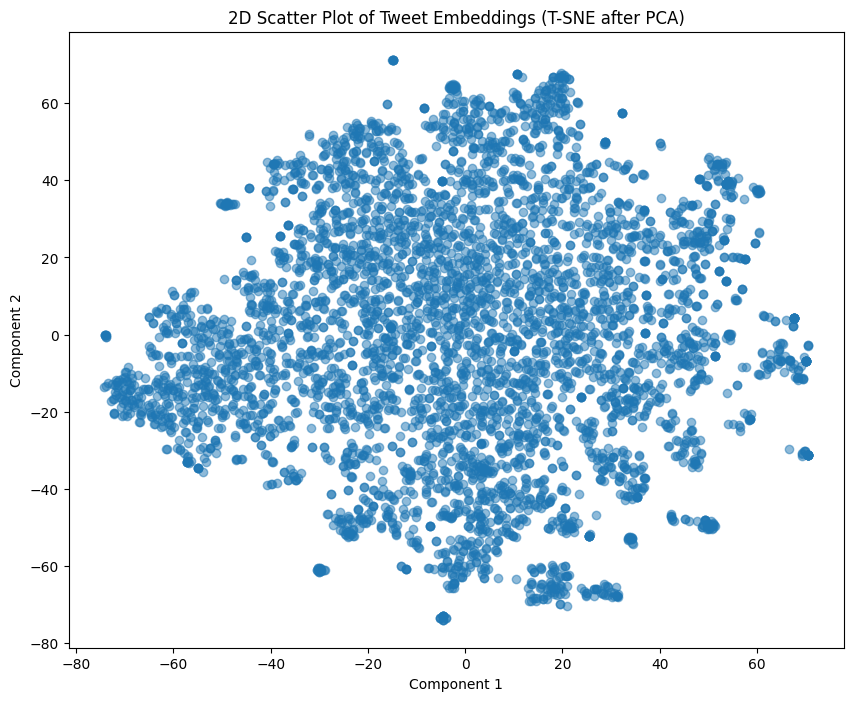

In [ ]:
# Tokenized tweets
tweets = [tweet['tweet'] for tweet in processed_tweets]

# Training Word2Vec on the tokenized tweets
model = Word2Vec(tweets, vector_size=100, min_count=5, window=10, workers=4)

# Initialize a list to store average tweet embeddings
tweet_embeddings = []

# Calculate the average word vector for each tweet
for tweet in tweets:
    word_vectors = [model.wv[word] for word in tweet if word in model.wv]
    if word_vectors:
        tweet_embeddings.append(np.mean(word_vectors, axis=0))
    else:
        tweet_embeddings.append(np.zeros(model.vector_size))
tweet_embeddings = np.array(tweet_embeddings)

# Subsample the tweet embeddings, using  10% of the data
tweet_embeddings = tweet_embeddings[np.random.choice(tweet_embeddings.shape[0], size=int(tweet_embeddings.shape[0] * 0.1), replace=False)]

# Reduce dimensions using PCA
pca = PCA(n_components=30)
tweet_embeddings_pca = pca.fit_transform(tweet_embeddings)

# Apply T-SNE to the PCA-reduced data
tsne = TSNE(n_components=2, random_state=0)
tweet_embeddings_tsne = tsne.fit_transform(tweet_embeddings_pca)

# Plot the 2D scatter plot
plt.figure(figsize=(10, 8))
plt.scatter(tweet_embeddings_tsne[:, 0], tweet_embeddings_tsne[:, 1], alpha=0.5)
plt.title("2D Scatter Plot of Tweet Embeddings (T-SNE after PCA)")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.show()